#### Data Source: 
Humphrey, Eric J., Durand, Simon, and McFee, Brian. "OpenMIC-2018: An Open Dataset for Multiple Instrument Recognition." in Proceedings of the 19th International Society for Music Information Retrieval Conference (ISMIR), 2018.

# General Data Processing

#### Packages and scripts can refer to github: https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
Data processing steps have been adjusted to suit CNN training

In [1]:
import numpy as np
import os
import librosa
import pandas as pd
import json
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

np.random.seed(42)

In [2]:
print(os.getcwd())  # This will print the current working directory

/Users/jiaozhitou


In [3]:
os.chdir('/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018')  # Replace with your actual path

In [4]:
! git clone https://github.com/cosmir/openmic-2018.git
! cd ./openmic-2018

fatal: destination path 'openmic-2018' already exists and is not an empty directory.


In [5]:
! ./scripts/download-deps.sh

Model parameters exist; skipping.
Model parameters exist; skipping.


In [6]:
# Load data

# Aggregated labels
labels = pd.read_csv('/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/openmic-2018-aggregated-labels.csv')
# Anonymized individual responses,
responses = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/openmic-2018-individual-responses.csv")
# Track metadata, with licenses for each audio recording
metadata = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/openmic-2018-metadata.csv")
# A Python-friendly NPZ file of features and labels, 'openmic-2018.npz'
OPENMIC = np.load('/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/openmic-2018.npz', allow_pickle=True)

print(OPENMIC.files)

X = OPENMIC['X']
Y_true = OPENMIC['Y_true']
Y_mask = OPENMIC['Y_mask']
sample_key = OPENMIC['sample_key']

['X', 'Y_true', 'Y_mask', 'sample_key']


In [7]:
# Check the balancy of samples
unique, counts = np.unique(np.argmax(Y_true, axis=1), return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

Class distribution: {0: 5882, 1: 1208, 2: 517, 3: 714, 4: 289, 5: 1062, 6: 849, 7: 535, 8: 1088, 9: 676, 10: 475, 11: 563, 12: 1117, 13: 862, 14: 1042, 15: 426, 16: 446, 17: 411, 18: 897, 19: 941}


In [8]:
# Normalize data

# Calculate the mean and standard deviation of the entire data set
mean = np.mean(X, axis=(0, 1))
std = np.std(X, axis=(0, 1))

# Ensure that the standard deviation is not zero
std[std == 0] = 1

# Standardize the training and test sets
X_normalized = (X - mean) / std

In [9]:
# retrieve class map
class_map_path = '/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/class-map.json'

with open(class_map_path, 'r') as f:
    class_map = json.load(f)

class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

In [10]:
# Sample partitions for train and test
split_test = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/partitions/split01_test.csv",header=None, squeeze=True)
split_train = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/partitions/split01_train.csv",header=None, squeeze=True)

train_set = set(split_train)
test_set = set(split_test)

/var/folders/l5/p52pkwd9449b8byxstmnf4zw0000gn/T/ipykernel_34932/2328183659.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  split_test = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/partitions/split01_test.csv",header=None, squeeze=True)
/var/folders/l5/p52pkwd9449b8byxstmnf4zw0000gn/T/ipykernel_34932/2328183659.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  split_train = pd.read_csv("/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/partitions/split01_train.csv",header=None, squeeze=True)


In [11]:
# prepare idx for data split
idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [12]:
# split data into train and test
X_train = X_normalized[idx_train]
X_test = X_normalized[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test= Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [13]:
# filter out the unlabeled samples
for instrument in class_map:
    
    inst_num = class_map[instrument]

    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]

    X_train_inst = X_train[train_inst]
    Y_true_train_inst = Y_true_train[train_inst]
    
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst]

In [14]:
# split the validation set
X_train_inst, X_val, Y_true_train_inst, Y_val = train_test_split(X_train_inst, Y_true_train_inst, test_size=0.1, random_state=42)

# CNN Training

In [15]:
# X_train is (number of samples, time, frequency)
X_train_inst_1 = np.expand_dims(X_train_inst, -1)  # Adding a dimension, the shape of the X_train should now be (number of samples, time, frequency, 1)
X_test_inst_1 = np.expand_dims(X_test_inst, -1)

In [16]:
# Calculate the number of samples in each category
class_counts = Y_true_train_inst.sum(axis=0)

# Calculate weights for each category
weights = (1 / class_counts) * (len(Y_true_train_inst) / len(class_counts))

# Create a dictionary of category weights
class_weights_dict = {i: weights[i] for i in range(len(class_counts))}

In [17]:
class_weights_dict

{0: 0.10338967539696423,
 1: 0.10344934502848624,
 2: 0.10542966723896632,
 3: 0.10529590213124412,
 4: 0.11033598905499957,
 5: 0.10200146687823795,
 6: 0.10138423080465664,
 7: 0.10755552993593769,
 8: 0.10106749355163912,
 9: 0.1059710899784595,
 10: 0.10660745224911862,
 11: 0.10548481648990654,
 12: 0.10711346416244523,
 13: 0.1083388986415253,
 14: 0.0981940455534188,
 15: 0.10643690870247446,
 16: 0.10668286997838453,
 17: 0.10363145519463554,
 18: 0.10341651072113463,
 19: 0.07888585768814498}

In [18]:
# set up the input shape
input_shape = X_train_inst_1.shape[1:]
num_classes = Y_true_train_inst.shape[1]

In [19]:
# model initialize
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# earlystopping function
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor the validation loss
    patience=3,  # 3 epochs
    verbose=1,  # print early stopping
    restore_best_weights=True  # back to best weight
)

# fit the model
history = model.fit(
    X_train_inst_1,
    Y_true_train_inst,
    epochs=20,
    batch_size=10,
    validation_data=(X_val, Y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_inst_1, Y_true_test_inst)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

Epoch 1/20
108/108 [==============================] - 4s 35ms/step - loss: 0.0604 - accuracy: 0.6237 - val_loss: 0.6741 - val_accuracy: 0.6555
Epoch 2/20
108/108 [==============================] - 4s 35ms/step - loss: 0.0593 - accuracy: 0.6863 - val_loss: 0.6683 - val_accuracy: 0.6891
Epoch 3/20
108/108 [==============================] - 4s 39ms/step - loss: 0.0590 - accuracy: 0.7134 - val_loss: 0.6658 - val_accuracy: 0.7479
Epoch 4/20
108/108 [==============================] - 4s 36ms/step - loss: 0.0588 - accuracy: 0.7180 - val_loss: 0.6635 - val_accuracy: 0.7647
Epoch 5/20
108/108 [==============================] - 4s 39ms/step - loss: 0.0586 - accuracy: 0.7442 - val_loss: 0.6637 - val_accuracy: 0.7479
Epoch 6/20
108/108 [==============================] - 4s 39ms/step - loss: 0.0585 - accuracy: 0.7432 - val_loss: 0.6647 - val_accuracy: 0.7479
Epoch 7/20
108/108 [==============================] - 4s 39ms/step - loss: 0.0583 - accuracy: 0.7526 - val_loss: 0.6628 - val_accuracy: 0.7731

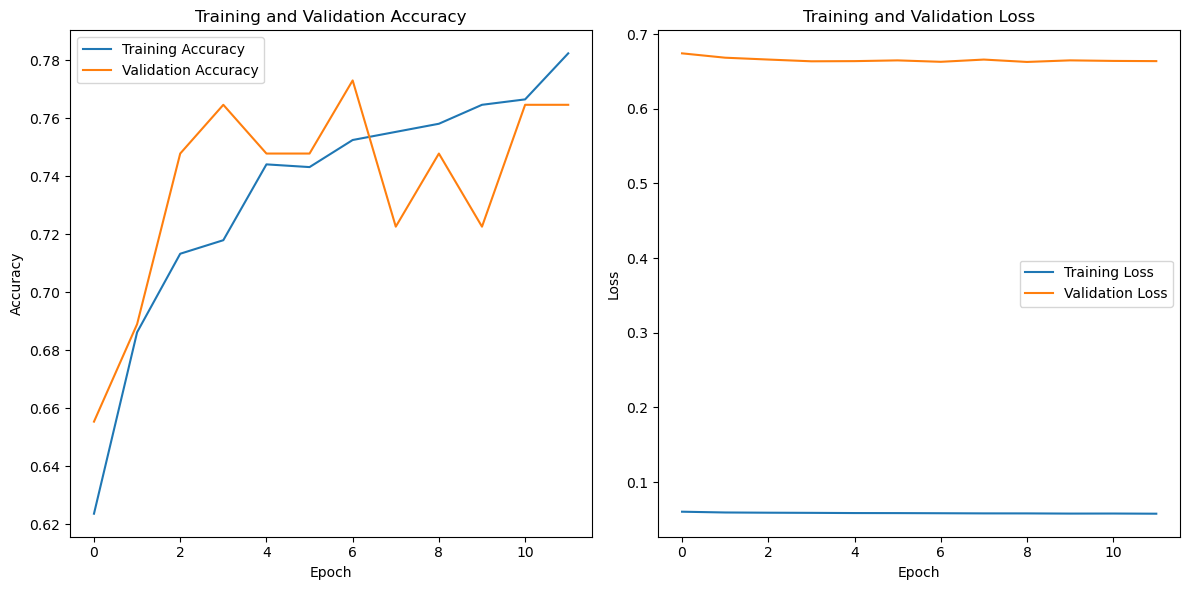

In [20]:
# Visualize the accuracy and loss of training set and validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
Y_val = (Y_val >= 0.5).astype(int)

In [22]:
# Get the predicted probability on the validation set
Y_pred_probs_val = model.predict(X_val)

best_thresholds = np.zeros(Y_pred_probs_val.shape[1])

for i in range(Y_pred_probs_val.shape[1]):
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.1, 1, 0.01):
        # Converting probabilities to binary predictions
        Y_pred_val = (Y_pred_probs_val[:, i] >= threshold).astype(int)
        # Calculating F1 scores
        f1 = f1_score(Y_val[:, i], Y_pred_val, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    best_thresholds[i] = best_threshold

best_thresholds

4/4 [==============================] - 0s 26ms/step


array([0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.37, 0.39, 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.37, 0.14])

In [23]:
Y_true_train_inst = (Y_true_train_inst >= 0.5).astype(int)
Y_true_test_inst = (Y_true_test_inst >= 0.5).astype(int)

In [24]:
# Getting the probability of a model prediction
Y_pred_probs_train = model.predict(X_train_inst_1)
Y_pred_probs_test = model.predict(X_test_inst_1)

# Converting prediction probabilities from training and test sets to binary predictions using optimal thresholds
Y_pred_train = (Y_pred_probs_train >= best_thresholds).astype(int)
Y_pred_test = (Y_pred_probs_test >= best_thresholds).astype(int)

# Convert the class indices to instrument names using class_map
target_names = [name for name, index in sorted(class_map.items(), key=lambda item: item[1])]

# Generate a classification report of the training set
print('TRAIN Classification Report')
print(classification_report(Y_true_train_inst, Y_pred_train, target_names=target_names))

# Generate a classification report of the testing set
print('TEST Classification Report')
print(classification_report(Y_true_test_inst, Y_pred_test, target_names=target_names))

12/12 [==============================] - 0s 29ms/step
TRAIN Classification Report
                   precision    recall  f1-score   support

        accordion       0.96      1.00      0.98      1027
            banjo       0.96      1.00      0.98      1032
             bass       0.93      1.00      0.96       996
            cello       0.94      1.00      0.97      1005
         clarinet       0.90      1.00      0.95       961
          cymbals       0.96      1.00      0.98      1024
            drums       0.97      0.99      0.98      1026
            flute       0.93      0.99      0.96       987
           guitar       0.95      1.00      0.97      1013
mallet_percussion       0.93      1.00      0.96       996
         mandolin       0.93      1.00      0.96       993
            organ       0.93      1.00      0.96       997
            piano       0.91      1.00      0.95       977
        saxophone       0.91      1.00      0.95       976
      synthesizer       0.93    

12/12 [==============================] - 0s 28ms/step


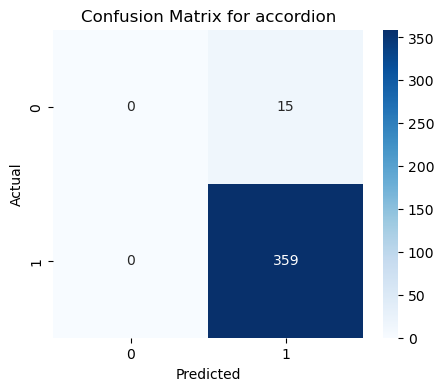

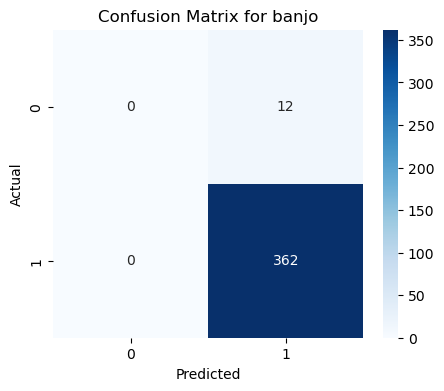

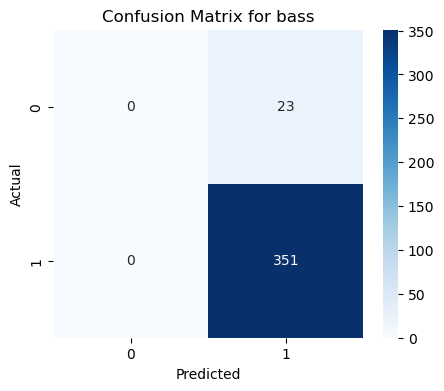

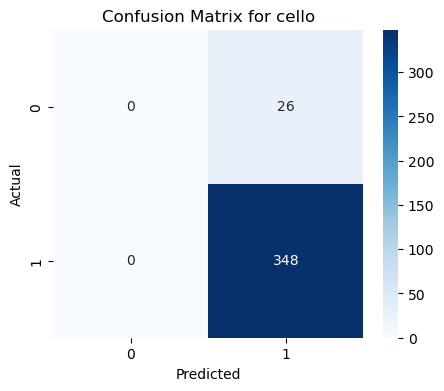

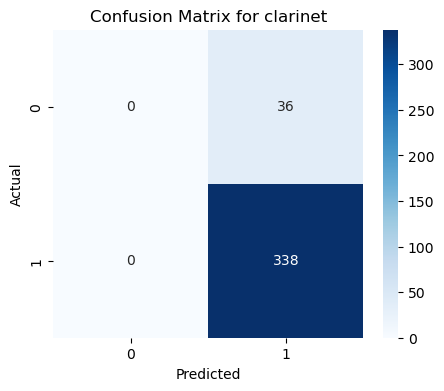

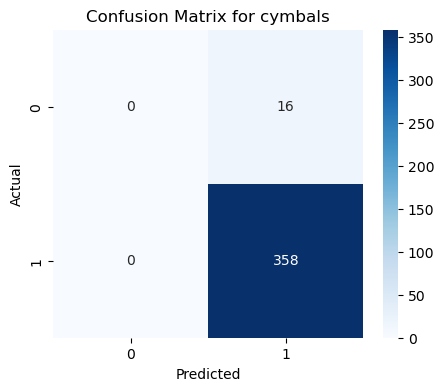

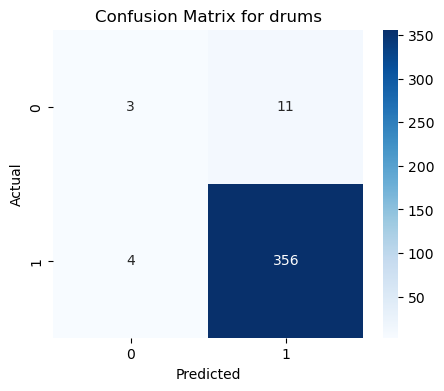

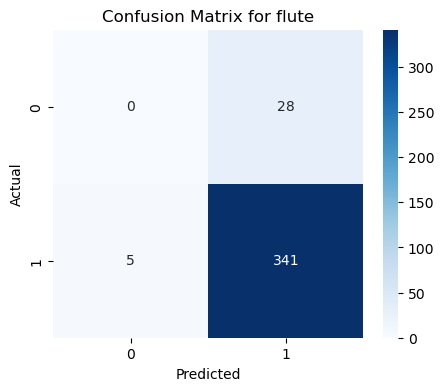

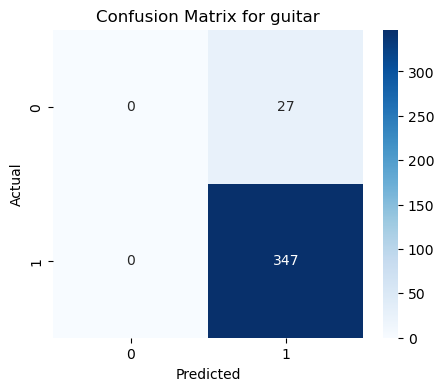

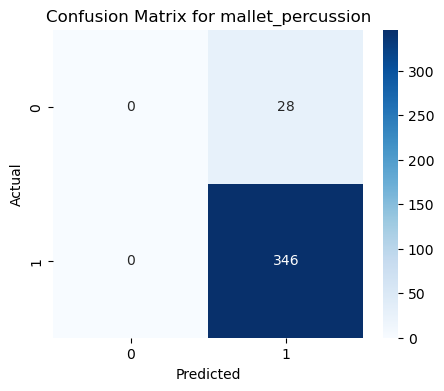

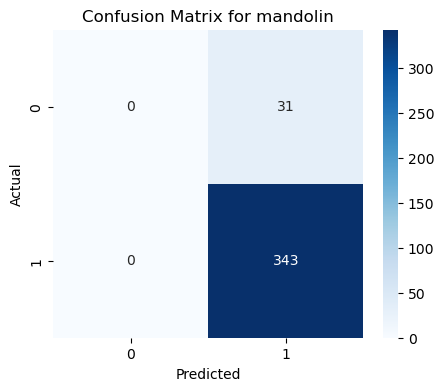

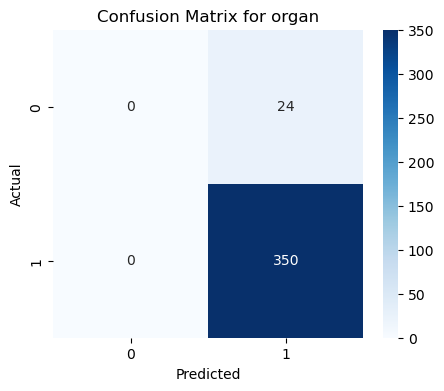

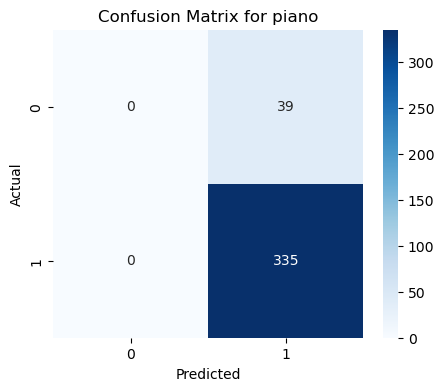

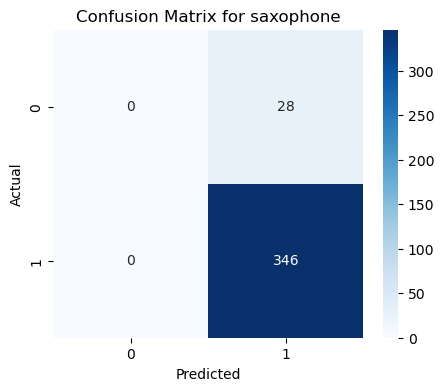

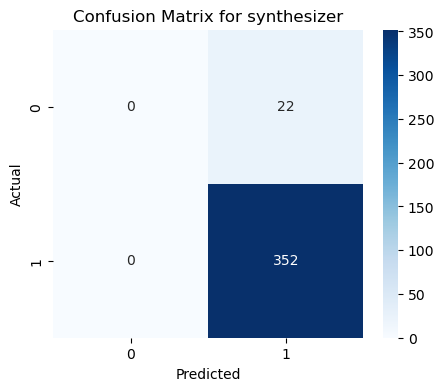

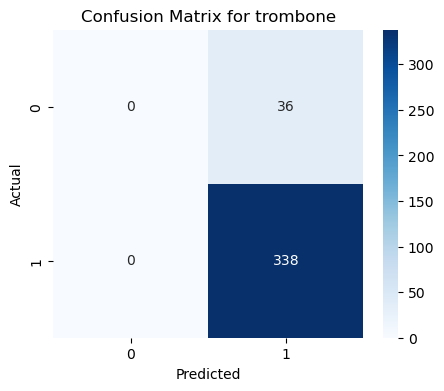

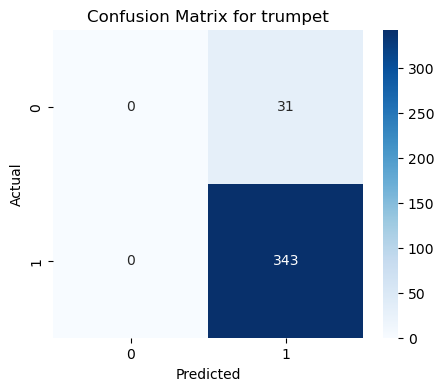

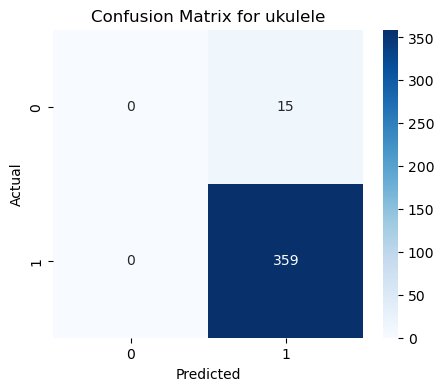

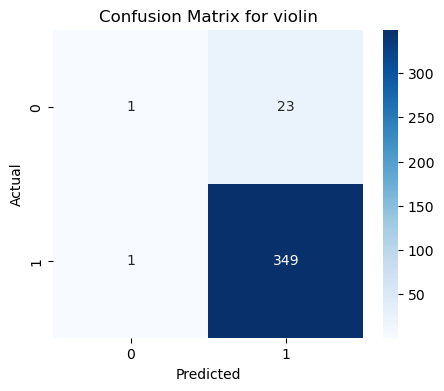

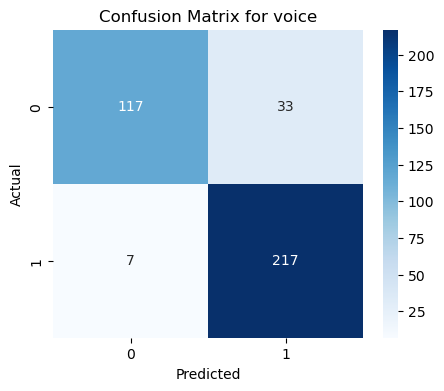

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probs_test = model.predict(X_test_inst_1)


for i in range(num_classes):
    Y_pred_test = (Y_pred_probs_test[:, i] >= best_thresholds[i]).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(Y_true_test_inst[:, i], Y_pred_test)
    
    # Visual Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {target_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### Visualization tool is from: 
@misc{Gavrikov2020VisualKeras,
  author = {Gavrikov, Paul},
  title = {visualkeras},
  year = {2020},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/paulgavrikov/visualkeras}},
}

In [26]:
# visualize CNN
!pip install visualkeras
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /private/var/folders/l5/p52pkwd9449b8byxstmnf4zw0000gn/T/pip-req-build-4nt08p1_
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /private/var/folders/l5/p52pkwd9449b8byxstmnf4zw0000gn/T/pip-req-build-4nt08p1_
  Resolved https://github.com/paulgavrikov/visualkeras to commit ccc27c21c2275973ff94e7bd773c4f11f78916d7
  Preparing metadata (setup.py) ... done


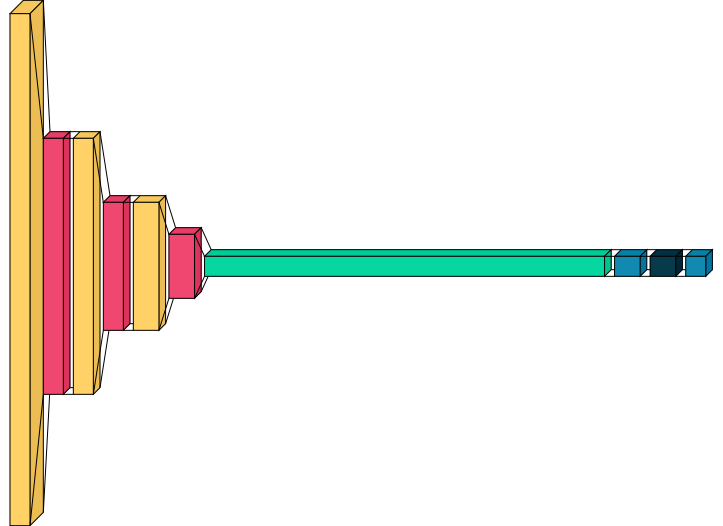

In [27]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

# RamdomForest Training

#### This is a pre-trained model from GitHub example: https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb

In [18]:
from sklearn.ensemble import RandomForestClassifier

# This dictionary will include the classifiers for each model
models = dict()

for instrument in class_map:
    
    inst_num = class_map[instrument]
        
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    X_train_inst = X_train[train_inst]

    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5

    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    clf.fit(X_train_inst_sklearn, Y_true_train_inst)

    Y_pred_train = clf.predict(X_train_inst_sklearn)
    Y_pred_test = clf.predict(X_test_inst_sklearn)
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    models[instrument] = clf

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1159
        True       1.00      0.88      0.94       374

    accuracy                           0.97      1533
   macro avg       0.98      0.94      0.96      1533
weighted avg       0.97      0.97      0.97      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.97      0.90       423
        True       0.77      0.32      0.45       115

    accuracy                           0.83       538
   macro avg       0.81      0.65      0.68       538
weighted avg       0.83      0.83      0.81       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1148
        True       0.97      0.97      0.97       592

    accuracy                           0

# Apply to New Audio

In [28]:
import os
import numpy as np
import soundfile as sf
from IPython.display import Audio
import openmic.vggish

In [29]:
audio, rate = sf.read(os.path.join('/Users/jiaozhitou/Desktop/UvA/ai/openmic-2018', 'audio/test_sample.ogg'))

time_points, features = openmic.vggish.waveform_to_features(audio, rate)

INFO:tensorflow:Restoring parameters from /Users/jiaozhitou/Desktop/UvA/ai/openmic-2018/openmic/vggish/_model/vggish_model.ckpt


/Users/jiaozhitou/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/jiaozhitou/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
2024-02-02 17:53:23.366477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


In [30]:
time_points

array([0.  , 0.96, 1.92, 2.88, 3.84, 4.8 , 5.76, 6.72, 7.68, 8.64])

In [31]:
features.shape

(10, 128)

In [32]:
Audio(data=audio.T, rate=rate)

In [33]:
if len(features.shape) == 2:
    features = np.expand_dims(features, axis=0)  # add sample number dimension
    features = np.expand_dims(features, axis=-1)  # add channel dimension

In [34]:
features.shape

(1, 10, 128, 1)

In [35]:
predictions = model.predict(features)

1/1 [==============================] - 0s 43ms/step


In [36]:
for i, class_name in enumerate(target_names):
    print('P[{:18s}=1] = {:.3f}'.format(class_name, predictions[0, i]))

P[accordion         =1] = 0.145
P[banjo             =1] = 0.000
P[bass              =1] = 0.000
P[cello             =1] = 1.000
P[clarinet          =1] = 0.000
P[cymbals           =1] = 0.000
P[drums             =1] = 0.000
P[flute             =1] = 0.000
P[guitar            =1] = 0.002
P[mallet_percussion =1] = 0.000
P[mandolin          =1] = 0.111
P[organ             =1] = 1.000
P[piano             =1] = 1.000
P[saxophone         =1] = 1.000
P[synthesizer       =1] = 0.000
P[trombone          =1] = 0.999
P[trumpet           =1] = 1.000
P[ukulele           =1] = 0.000
P[violin            =1] = 1.000
P[voice             =1] = 0.000
